In [ ]:
!pip install ipdb #For debugging
!pip install tqdm #For the progress bar
!pip install numpy matplotlib tensorflow
!pip install jax jaxlib #Install jax and jaxlib, which stax depends on.
!pip install -U stax #Reinstall stax to ensure the latest version
!pip install --upgrade neural-tangents #Update neural-tangents

In the next cell we generate a plot of 100 trained single-layer neural networks and the mean and covariance of the GP at time t=epochs*learning_rate, both over a test set of 50 points.

There are a few hyperparameters to experiment with:

*   `activation_function`: Selects the non-linear activation function used in the hidden layer of the neural network. Available options are `'relu'`, `'erf'`, and `'sigmoid'`.
*   `num_samples`: Determines the number of data points in the training set. Varying this parameter allows for observing the effect of training data size on both the trained networks and the GP.
In this example we adopt `num_samples=2` as default so that the training fit is noticeable in the plotted image.
*   `num_networks`: Specifies the number of parallel neural networks trained.
*   `hidden_units`: Controls the width ($n_1$) of the hidden layer. This is a crucial parameter for studying the transition from finite-width networks to the infinite-width NTK/GP limit. The scaling of the learning rate (`scaled_lr`) is dependent on this parameter, as in [Lee et al., 2019, Appendix H].
*   `learning_rate`: The base learning rate used for the optimizer. The effective learning rate applied to the network parameters is `scaled_lr`, which incorporates the `hidden_units` scaling as indicated in the above point.
*   `epochs`: The total number of training iterations. This parameter corresponds to the 'time' parameter in the finite-time GP analysis, with the relation `time = epochs * scaled_lr`. Investigating different epoch values allows for observing the evolution of the network ensemble and GP over training time.
*   `training_data_seed`: An integer seed used to generate the random training data, for reproducibility.



Using device: cpu
Epochs > 0, using finite time GP mean and covariance with epochs=10000 and lr=0.5.


Training Networks: 100%|██████████| 10000/10000 [00:38<00:00, 262.92it/s]


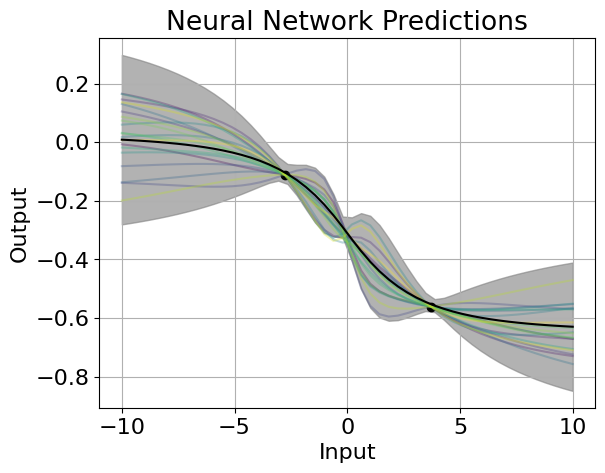

----------------------------------------
Plot Information:
  Activation Function: sigmoid
  Number of Networks: 20
  Hidden Units: 700
  Epochs: 10000
  Learning Rate: 0.5
  Effective Training Time: 7.1429
  Training Data Seed: 5
----------------------------------------


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.linalg

import jax.numpy as jnp
from jax import random
import jax
import neural_tangents as nt
from neural_tangents import stax

from tqdm import tqdm # Use standard tqdm, works in notebooks and scripts

# Generate 1-dimensional training data, set hyperparameters
activation_function = 'sigmoid'   # available options: 'relu', 'erf', 'sigmoid'
num_samples = 2                   # cardinality of training set
num_networks = 20                 # Number of networks to plot
hidden_units = 700 #100                # Width of the hidden layer (n_1 in the paper)
learning_rate = 0.5 #0.1
epochs =10000 #100000
scaled_lr = learning_rate / hidden_units  # Learning rate for NTK scaling

# Set a seed for reproducible training data generation
training_data_seed = 5
np.random.seed(training_data_seed)

# Generate training set
x_train = np.random.uniform(low=-5, high=5, size=(num_samples, 1))
y_train = np.sin(x_train) + 0.1 * np.random.randn(num_samples, 1)  # Example function to learn
# Generate test set
x_test = np.linspace(-10, 10, 50).reshape(-1, 1)


# --- PyTorch Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- PyTorch Batched Shallow NN --- NTK scaling
class BatchedShallowNN_Pytorch(nn.Module):
    def __init__(self, input_dim, hidden_units, num_parallel_networks, W_std=1.0, B_std=0.0):
        super(BatchedShallowNN_Pytorch, self).__init__()
        self.num_parallel_networks = num_parallel_networks
        self.hidden_units = hidden_units

        # Parameters will have an extra dimension for num_parallel_networks
        # Layer 1 weights and biases

        self.w1 = nn.Parameter(torch.randn(num_parallel_networks, hidden_units, input_dim) / torch.sqrt(torch.tensor(input_dim, dtype=torch.float32)))  #GPT fix

        #self.w1 = nn.Parameter(torch.randn(num_parallel_networks, hidden_units, input_dim) * W_std)
        self.b1 = nn.Parameter(torch.zeros(num_parallel_networks, hidden_units))

        # Layer 2 weights and biases
        self.w2 = nn.Parameter(torch.randn(num_parallel_networks, 1, hidden_units) * W_std)
        self.b2 = nn.Parameter(torch.zeros(num_parallel_networks, 1) * B_std)

        #Activation function selection
        if activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'erf':
            self.activation = torch.erf # Assign the function itself, not the result of calling it since its not an nn module

        # NTK Scaling factor
        self.ntk_scale = torch.sqrt(torch.tensor(hidden_units, dtype=torch.float32))

    def forward(self, x):
        # Hidden layer computation
        # (N, H, D_in) @ (B, D_in).T = (N, H, D_in) @ (D_in, B) -> (N, H, B)
        # N = num_parallel_networks, H = hidden_units, D_in = input_dim, B = batch_size_data
        hidden_lin = torch.einsum('nhd,bd->nhb', self.w1, x) + self.b1.unsqueeze(2) # unsqueeze for broadcasting over data batch
        hidden_act = self.activation(hidden_lin)

        # Output layer computation
        # (N, O, H) @ (N, H, B) -> (N, O, B) where O=1 (output_dim)
        outputs_lin = torch.einsum('noh,nhb->nob', self.w2, hidden_act) + self.b2.unsqueeze(2)

        # NTK Scaling
        outputs_scaled = outputs_lin / self.ntk_scale # NTK scaling

        # Reshape to (num_parallel_networks, batch_size_data, output_dim)
        # Current shape is (num_parallel_networks, output_dim, batch_size_data)
        return outputs_scaled.transpose(1, 2)

# --- Train Batched PyTorch Networks ---
def train_batched_networks_pytorch(width, num_parallel_train_networks,
                                   x_train_np_local, y_train_np_local, x_test_np_local,
                                   epochs_local, lr_local, current_device, seed=None): # Add seed parameter

    if seed is not None:
        torch.manual_seed(seed) # Set PyTorch seed for reproducibility

    model = BatchedShallowNN_Pytorch(input_dim=x_train_np_local.shape[1],
                                     hidden_units=width,
                                     num_parallel_networks=num_parallel_train_networks).to(current_device)

    x_train_torch = torch.from_numpy(x_train_np_local).float().to(current_device)
    y_train_torch = torch.from_numpy(y_train_np_local).float().to(current_device)
    x_test_torch = torch.from_numpy(x_test_np_local).float().to(current_device)

    if epochs_local > 0:
        optimizer = optim.SGD(model.parameters(), lr=lr_local)
        criterion = nn.MSELoss()

        # Expand y_train to match batched output shape: (num_parallel_networks, batch_size_data, output_dim)
        y_train_expanded = y_train_torch.unsqueeze(0).expand(num_parallel_train_networks, -1, -1)

        model.train()
        for epoch_idx in tqdm(range(epochs_local), desc="Training Networks"): # Add tqdm here
            optimizer.zero_grad()
            outputs = model(x_train_torch) # Shape: (num_parallel, batch_data, out_dim)

            criterion = nn.MSELoss(reduction='none')                            #GPT fix (averaging over N*B elements)
            loss = criterion(outputs, y_train_expanded).mean(dim=(1, 2)).mean() #GPT fix (averaging over N*B elements) ?

            #loss = criterion(outputs, y_train_expanded) # Will average over all N*B*O elements
            loss.backward()
            optimizer.step()

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions_batched = model(x_test_torch) # Shape: (num_parallel, batch_test_data, out_dim)

    # Return as numpy array, flatten last two dims if output_dim is 1
    # Shape: (num_parallel_train_networks, num_test_inputs)
    return predictions_batched.cpu().numpy().reshape(num_parallel_train_networks, -1)

# --- It function ---
def It(k, t):
    # Add a small diagonal jitter to handle singularity
    k_reg = k + np.eye(k.shape[0]) * 1e-6
    # Solve linear system kX = I - e^{-kt}
    b_matrix = np.identity(k_reg.shape[0]) - scipy.linalg.expm(-k_reg * t)
    return np.linalg.solve(k_reg, b_matrix)


def It_discrete(K, eta, T):
    # returns K^{-1} (I - (I - eta K)^T)
    I = np.eye(K.shape[0])
    M = I - eta * K
    Mpow = np.linalg.matrix_power(M, T)
    b = I - Mpow
    return np.linalg.solve(K + 1e-12 * I, b)  # stable solve

# --- GP Calculation ---
# Width in stax.Dense is just a placeholder for NTK computation, doesn't affect the kernel value for infinite width limit
# kernel_fn is stateless, so safe to define once
# Select activation function for NTK computation
if activation_function == 'sigmoid':
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(10, W_std=1.0, b_std=0.0), stax.Sigmoid_like(),
        stax.Dense(1, W_std=1.0, b_std=0.0)
    )
elif activation_function == 'relu':
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(10, W_std=1.0, b_std=0.0), stax.Relu(),  # Use stax.Relu() for ReLU
        stax.Dense(1, W_std=1.0, b_std=0.0)
    )
elif activation_function == 'erf':  # Using built-in stax.Erf
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(10, W_std=1.0, b_std=0.0), stax.Erf(),
        stax.Dense(1, W_std=1.0, b_std=0.0)
    )

# Convert JAX arrays to NumPy for subsequent scipy/numpy operations if needed
k2_test_test_jax = kernel_fn(x_test, x_test, 'nngp')
k2_test_train_jax = kernel_fn(x_test, x_train, 'nngp')
k2_train_test_jax = kernel_fn(x_train, x_test, 'nngp')
k2_train_train_jax = kernel_fn(x_train, x_train, 'nngp')

kinf_test_train_jax = kernel_fn(x_test, x_train, 'ntk')
kinf_train_train_jax = kernel_fn(x_train, x_train, 'ntk')

# Convert JAX arrays to NumPy. .block_until_ready() is good practice for JAX before conversion.
k2_test_test = np.array(k2_test_test_jax.block_until_ready())
k2_test_train = np.array(k2_test_train_jax.block_until_ready())
k2_train_test = np.array(k2_train_test_jax.block_until_ready())
k2_train_train = np.array(k2_train_train_jax.block_until_ready())

kinf_test_train = np.array(kinf_test_train_jax.block_until_ready())
kinf_train_train = np.array(kinf_train_train_jax.block_until_ready())
# kinf_train_test is just kinf_test_train.T
kinf_train_test = kinf_test_train.T

# GP mean and covariance calculation
if epochs == 0: # At initialization
    gp_mean = np.zeros_like(x_test @ y_train.T)
    gp_cov = k2_test_test
    print("Epochs = 0, using GP mean (0) and covariance (NNGP K(x_test,x_test)).")

else: # epochs > 0

    #Itk = It_discrete(kinf_train_train, learning_rate, epochs)   # discrete version GPT fix
    #Itk = It(kinf_train_train, epochs * learning_rate)       # Use unscaled time
    Itk = It(kinf_train_train, epochs * scaled_lr)            # Use scaled time
    gp_mean = kinf_test_train @ Itk @ y_train

    pz1 = k2_test_test
    pz2 = -k2_test_train @ Itk @ kinf_train_test
    pz3 = -kinf_test_train @ Itk @ k2_train_test
    pz4 = +kinf_test_train @ Itk @ k2_train_train @ Itk @ kinf_train_test
    gp_cov = pz1 + pz2 + pz3 + pz4
    print(f"Epochs > 0, using finite time GP mean and covariance with epochs={epochs} and lr={learning_rate}.")

# Ensure gp_cov is positive semi-definite for sampling
gp_cov = gp_cov + np.eye(gp_cov.shape[0]) * 1e-6

gp_std = np.sqrt(np.diag(gp_cov)) # Calculating gp_std from gp_cov

# Train/evaluate batched networks
# Note: We are not setting a seed for the PyTorch model initialization here.
# To make network initialization reproducible, you would also need to set torch.manual_seed()
# before creating the BatchedShallowNN_Pytorch instance.
nn_outputs = train_batched_networks_pytorch(
    width=hidden_units,
    num_parallel_train_networks=num_networks,
    x_train_np_local=x_train,
    y_train_np_local=y_train,
    x_test_np_local=x_test,
    epochs_local=epochs,
    #lr_local=scaled_lr,
    lr_local=learning_rate,
    current_device=device,
    seed=training_data_seed # Pass the seed to the training function
)

# Create a colormap for the network predictions
cmap = plt.get_cmap('viridis')                  # Choose a colormap you like
colors = cmap(np.linspace(0, 1, num_networks))  # Generate colors for each network
# Plot individual network predictions
for i in range(num_networks):
    plt.plot(x_test, nn_outputs[i], color=colors[i], alpha=0.3)  # Adjust color and alpha as desired

# Plot the GP mean and std
plt.plot(x_test, gp_mean, color='black', label='GP Mean')
plt.fill_between(
    x_test.ravel(),
    gp_mean[:, 0].ravel() - 1.95*gp_std,  # Select the first output column
    gp_mean[:, 0].ravel() + 1.95*gp_std,  # Select the first output column
    color='gray',
    alpha=0.6,
    label='GP 95% Confidence Interval'
)
# Plot training data
font = 16
plt.scatter(x_train, y_train, color='black', label='Training Data')
plt.rcParams.update({'font.size': font})
plt.title('Neural Network Predictions')
plt.xlabel('Input', fontsize=font)
plt.ylabel('Output',fontsize=font)
plt.grid(True)

plt.show()

# Print plot_info in a formatted way
print("-" * 40)
print("Plot Information:")
print(f"  Activation Function: {activation_function}")
print(f"  Number of Networks: {num_networks}")
print(f"  Hidden Units: {hidden_units}")
print(f"  Epochs: {epochs}")
print(f"  Learning Rate: {learning_rate}")
print(f"  Effective Training Time: {epochs * scaled_lr:.4f}") # Added effective training time
print(f"  Training Data Seed: {training_data_seed}") # Print the seed used
print("-" * 40)  # Print a separator line

# Analogous with standard scaling

As opposed to the previous cell, this cell uses the standard scaling in the training of the networks instead of the NTK scaling. In the wide limit the dynamics are equivalent, as demonstrated in the cell after this one.

Using device: cpu
Epochs > 0, using finite time GP mean and covariance with epochs=10000 and lr=0.0001.


Training Networks: 100%|██████████| 10000/10000 [00:37<00:00, 266.38it/s]


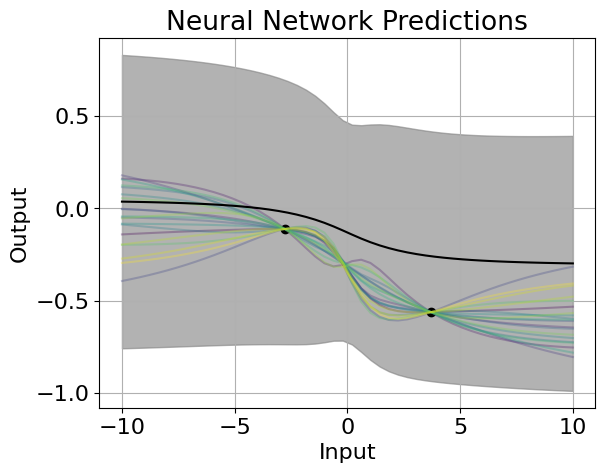

----------------------------------------
Plot Information:
  Activation Function: sigmoid
  Number of Networks: 20
  Hidden Units: 1000
  Epochs: 10000
  Learning Rate: 0.0001
  Training Data Seed: 5
----------------------------------------


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.linalg

import jax.numpy as jnp
from jax import random
import jax
import neural_tangents as nt
from neural_tangents import stax

from tqdm import tqdm # Use standard tqdm, works in notebooks and scripts

# Generate 1-dimensional training data, set hyperparameters
activation_function = 'sigmoid'   # available options: 'relu', 'erf', 'sigmoid'
num_samples = 2                   # cardinality of training set
num_networks = 20                 # Number of networks to plot
hidden_units = 1000 #100                # Width of the hidden layer (n_1 in the paper)
learning_rate = 0.0001 #0.1
epochs = 10000 #100000
# Remove scaled_lr calculation
# scaled_lr = learning_rate / hidden_units  # Learning rate for NTK scaling

# Set a seed for reproducible training data generation
training_data_seed = 5
np.random.seed(training_data_seed)

# Generate training set
x_train = np.random.uniform(low=-5, high=5, size=(num_samples, 1))
y_train = np.sin(x_train) + 0.1 * np.random.randn(num_samples, 1)  # Example function to learn
# Generate test set
x_test = np.linspace(-10, 10, 50).reshape(-1, 1)


# --- PyTorch Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- PyTorch Batched Shallow NN --- Standard scaling
class BatchedShallowNN_PytorchSTD(nn.Module):
    def __init__(self, input_dim, hidden_units, num_parallel_networks, W_std=1.0, B_std=0.0):
        super(BatchedShallowNN_PytorchSTD, self).__init__()
        self.num_parallel_networks = num_parallel_networks
        self.hidden_units = hidden_units
        self.input_dim = input_dim # Store input_dim

        # Parameters will have an extra dimension for num_parallel_networks
        # Layer 1 weights and biases

        # Standard scaling for W1: W_std = 1.0 / sqrt(input_dim)
        self.w1 = nn.Parameter(torch.randn(num_parallel_networks, hidden_units, input_dim) * (1.0 / np.sqrt(input_dim))) # Standard scaling in weight init
        self.b1 = nn.Parameter(torch.zeros(num_parallel_networks, hidden_units) * B_std)

        # Standard scaling for W2: W_std = 1.0 / sqrt(hidden_units)
        self.w2 = nn.Parameter(torch.randn(num_parallel_networks, 1, hidden_units) * (1.0 / np.sqrt(hidden_units))) # Standard scaling in weight init
        self.b2 = nn.Parameter(torch.zeros(num_parallel_networks, 1) * B_std)


        #Activation function selection
        if activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'erf':
            self.activation = torch.erf # Assign the function itself, not the result of calling it since its not an nn module

        # Remove NTK Scaling factor
        #self.ntk_scale = torch.sqrt(torch.tensor(hidden_units, dtype=torch.float32))

    def forward(self, x):
        # Hidden layer computation
        # (N, H, D_in) @ (B, D_in).T = (N, H, D_in) @ (D_in, B) -> (N, H, B)
        # N = num_parallel_networks, H = hidden_units, D_in = input_dim, B = batch_size_data
        hidden_lin = torch.einsum('nhd,bd->nhb', self.w1, x) + self.b1.unsqueeze(2) # unsqueeze for broadcasting over data batch
        hidden_act = self.activation(hidden_lin)

        # Output layer computation
        # (N, O, H) @ (N, H, B) -> (N, O, B) where O=1 (output_dim)
        outputs_lin = torch.einsum('noh,nhb->nob', self.w2, hidden_act) + self.b2.unsqueeze(2)

        # Remove NTK Scaling
        # outputs_scaled = outputs_lin / self.ntk_scale # NTK scaling

        # Reshape to (num_parallel_networks, batch_size_data, output_dim)
        # Current shape is (num_parallel_networks, output_dim, batch_size_data)
        return outputs_lin.transpose(1, 2) # Return unscaled outputs


# --- Train Batched PyTorch Networks ---
def train_batched_networks_pytorchSTD(width, num_parallel_train_networks,
                                   x_train_np_local, y_train_np_local, x_test_np_local,
                                   epochs_local, lr_local, current_device, seed=None): # Add seed parameter

    if seed is not None:
        torch.manual_seed(seed) # Set PyTorch seed for reproducibility

    model = BatchedShallowNN_PytorchSTD(input_dim=x_train_np_local.shape[1],
                                     hidden_units=width,
                                     num_parallel_networks=num_parallel_train_networks).to(current_device)

    x_train_torch = torch.from_numpy(x_train_np_local).float().to(current_device)
    y_train_torch = torch.from_numpy(y_train_np_local).float().to(current_device)
    x_test_torch = torch.from_numpy(x_test_np_local).float().to(current_device)

    if epochs_local > 0:
        optimizer = optim.SGD(model.parameters(), lr=lr_local)
        criterion = nn.MSELoss()

        # Expand y_train to match batched output shape: (num_parallel_networks, batch_size_data, output_dim)
        y_train_expanded = y_train_torch.unsqueeze(0).expand(num_parallel_train_networks, -1, -1)

        model.train()
        for epoch_idx in tqdm(range(epochs_local), desc="Training Networks"): # Add tqdm here
            optimizer.zero_grad()
            outputs = model(x_train_torch) # Shape: (num_parallel, batch_data, out_dim)

            criterion = nn.MSELoss(reduction='none')
            loss = criterion(outputs, y_train_expanded).mean(dim=(1, 2)).mean()

            #loss = criterion(outputs, y_train_expanded) # Will average over all N*B*O elements
            loss.backward()
            optimizer.step()

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions_batched = model(x_test_torch) # Shape: (num_parallel, batch_test_data, out_dim)

    # Return as numpy array, flatten last two dims if output_dim is 1
    # Shape: (num_parallel_train_networks, num_test_inputs)
    return predictions_batched.cpu().numpy().reshape(num_parallel_train_networks, -1)

# --- It function ---
def It(k, t):
    # Add a small diagonal jitter to handle singularity
    k_reg = k + np.eye(k.shape[0]) * 1e-6
    # Solve linear system kX = I - e^{-kt}
    b_matrix = np.identity(k_reg.shape[0]) - scipy.linalg.expm(-k_reg * t)
    return np.linalg.solve(k_reg, b_matrix)


def It_discrete(K, eta, T):
    # returns K^{-1} (I - (I - eta K)^T)
    I = np.eye(K.shape[0])
    M = I - eta * K
    Mpow = np.linalg.matrix_power(M, T)
    b = I - Mpow
    return np.linalg.solve(K + 1e-12 * I, b)  # stable solve

# --- GP Calculation ---
# Width in stax.Dense is just a placeholder for NTK computation, doesn't affect the kernel value for infinite width limit
# kernel_fn is stateless, so safe to define once
# Select activation function for NTK computation
if activation_function == 'sigmoid':
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(10, W_std=1.0, b_std=0.0), stax.Sigmoid_like(),
        stax.Dense(1, W_std=1.0, b_std=0.0)
    )
elif activation_function == 'relu':
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(10, W_std=1.0, b_std=0.0), stax.Relu(),  # Use stax.Relu() for ReLU
        stax.Dense(1, W_std=1.0, b_std=0.0)
    )
elif activation_function == 'erf':  # Using built-in stax.Erf
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(10, W_std=1.0, b_std=0.0), stax.Erf(),
        stax.Dense(1, W_std=1.0, b_std=0.0)
    )

# Convert JAX arrays to NumPy for subsequent scipy/numpy operations if needed
k2_test_test_jax = kernel_fn(x_test, x_test, 'nngp')
k2_test_train_jax = kernel_fn(x_test, x_train, 'nngp')
k2_train_test_jax = kernel_fn(x_train, x_test, 'nngp')
k2_train_train_jax = kernel_fn(x_train, x_train, 'nngp')

kinf_test_train_jax = kernel_fn(x_test, x_train, 'ntk')
kinf_train_train_jax = kernel_fn(x_train, x_train, 'ntk')

# Convert JAX arrays to NumPy. .block_until_ready() is good practice for JAX before conversion.
k2_test_test = np.array(k2_test_test_jax.block_until_ready())
k2_test_train = np.array(k2_test_train_jax.block_until_ready())
k2_train_test = np.array(k2_train_test_jax.block_until_ready())
k2_train_train = np.array(k2_train_train_jax.block_until_ready())

kinf_test_train = np.array(kinf_test_train_jax.block_until_ready())
kinf_train_train = np.array(kinf_train_train_jax.block_until_ready())
# kinf_train_test is just kinf_test_train.T
kinf_train_test = kinf_test_train.T

# GP mean and covariance calculation
if epochs == 0: # At initialization
    gp_mean = np.zeros_like(x_test @ y_train.T)
    gp_cov = k2_test_test # Use NNGP kernel for covariance at initialization
    print("Epochs = 0, using GP mean (0) and covariance (NNGP K(x_test,x_test)).")

else: # epochs > 0
    # Use unscaled learning_rate and epochs for time in Itk
    Itk = It(kinf_train_train, epochs * learning_rate)
    gp_mean = kinf_test_train @ Itk @ y_train

    pz1 = k2_test_test
    pz2 = -k2_test_train @ Itk @ kinf_train_test
    pz3 = -kinf_test_train @ Itk @ k2_train_test
    pz4 = +kinf_test_train @ Itk @ k2_train_train @ Itk @ kinf_train_test
    gp_cov = pz1 + pz2 + pz3 + pz4
    print(f"Epochs > 0, using finite time GP mean and covariance with epochs={epochs} and lr={learning_rate}.")

# Ensure gp_cov is positive semi-definite for sampling
gp_cov = gp_cov + np.eye(gp_cov.shape[0]) * 1e-6

gp_std = np.sqrt(np.diag(gp_cov)) # Calculating gp_std from gp_cov

# Train/evaluate batched networks
# Note: We are not setting a seed for the PyTorch model initialization here.
# To make network initialization reproducible, you would also need to set torch.manual_seed()
# before creating the BatchedShallowNN_Pytorch instance.
nn_outputs = train_batched_networks_pytorchSTD(
    width=hidden_units,
    num_parallel_train_networks=num_networks,
    x_train_np_local=x_train,
    y_train_np_local=y_train,
    x_test_np_local=x_test,
    epochs_local=epochs,
    lr_local=learning_rate, # Use unscaled learning rate for training
    current_device=device,
    seed=training_data_seed # Pass the seed to the training function
)

# Create a colormap for the network predictions
cmap = plt.get_cmap('viridis')                  # Choose a colormap you like
colors = cmap(np.linspace(0, 1, num_networks))  # Generate colors for each network
# Plot individual network predictions
for i in range(num_networks):
    plt.plot(x_test, nn_outputs[i], color=colors[i], alpha=0.3)  # Adjust color and alpha as desired

# Plot the GP mean and std
plt.plot(x_test, gp_mean, color='black', label='GP Mean')
plt.fill_between(
    x_test.ravel(),
    gp_mean[:, 0].ravel() - 1.95*gp_std,  # Select the first output column
    gp_mean[:, 0].ravel() + 1.95*gp_std,  # Select the first output column
    color='gray',
    alpha=0.6,
    label='GP 95% Confidence Interval'
)
# Plot training data
font = 16
plt.scatter(x_train, y_train, color='black', label='Training Data')
plt.rcParams.update({'font.size': font})
plt.title('Neural Network Predictions')
plt.xlabel('Input', fontsize=font)
plt.ylabel('Output',fontsize=font)
plt.grid(True)

plt.show()

# Print plot_info in a formatted way
print("-" * 40)
print("Plot Information:")
print(f"  Activation Function: {activation_function}")
print(f"  Number of Networks: {num_networks}")
print(f"  Hidden Units: {hidden_units}")
print(f"  Epochs: {epochs}")
print(f"  Learning Rate: {learning_rate}")
print(f"  Training Data Seed: {training_data_seed}") # Print the seed used
print("-" * 40)  # Print a separator line

# Comparison NTK vs standard scaling dynamics

Standard Scaling Learning Rate: 0.0002
NTK Scaling Learning Rate: 0.1
Effective Training Time (Standard): 1.0
Effective Training Time (NTK): 1.0
Using device: cpu


Training Networks: 100%|██████████| 5000/5000 [00:07<00:00, 635.19it/s]


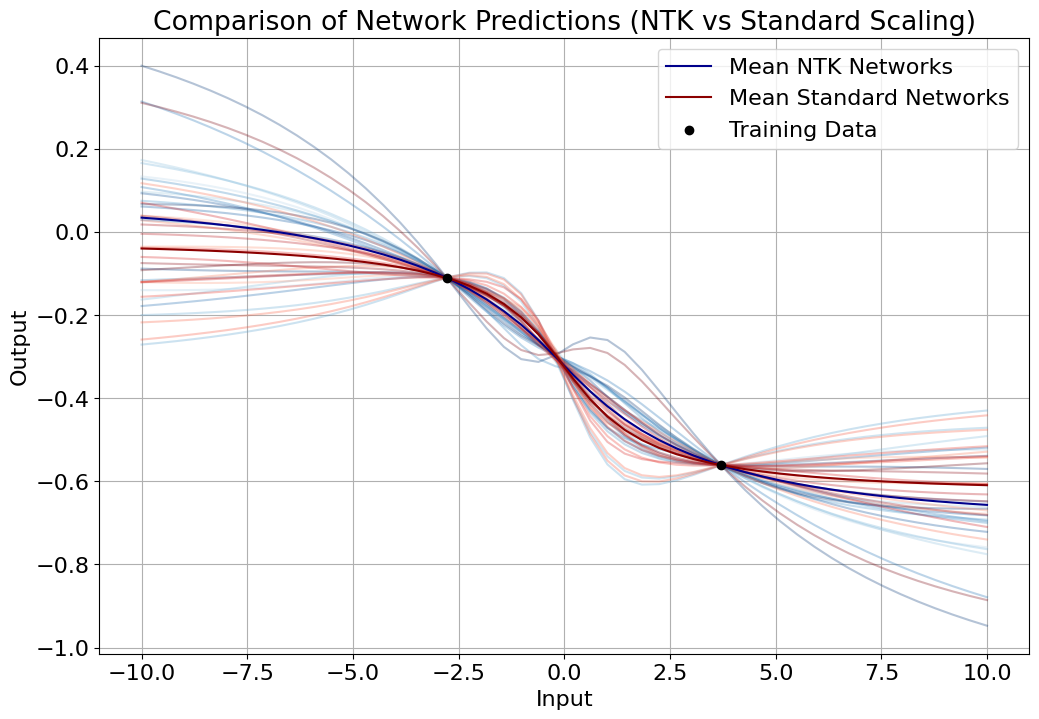

----------------------------------------
Comparison Plot Information:
  Activation Function: sigmoid
  Number of Networks (each): 20
  Hidden Units: 500
  Epochs: 5000
  Learning Rate (Standard): 0.0002
  Learning Rate (NTK): 0.1
  Effective Training Time: 1.0
  Training Data Seed: 5
----------------------------------------


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.linalg

import jax.numpy as jnp
from jax import random
import jax
import neural_tangents as nt
from neural_tangents import stax

from tqdm import tqdm

# --- Parameters ---
activation_function = 'sigmoid'   # available options: 'relu', 'erf', 'sigmoid'
num_samples = 2                   # cardinality of training set
num_networks = 20                 # Number of networks to plot (for each scaling)
hidden_units = 500               # Width of the hidden layer
learning_rate_std = 0.0002         # Base learning rate for standard scaling
epochs = 5000                     # Number of epochs

# Calculate learning rate for NTK scaling to match effective time
learning_rate_ntk = learning_rate_std * hidden_units
scaled_lr_ntk = learning_rate_ntk / hidden_units # This should be equal to learning_rate_std

print(f"Standard Scaling Learning Rate: {learning_rate_std}")
print(f"NTK Scaling Learning Rate: {learning_rate_ntk}")
print(f"Effective Training Time (Standard): {epochs * learning_rate_std}")
print(f"Effective Training Time (NTK): {epochs * scaled_lr_ntk}")


# Set a seed for reproducible training data generation
training_data_seed = 5
np.random.seed(training_data_seed)
torch.manual_seed(training_data_seed) # Set PyTorch seed for reproducibility

# Generate training set
x_train = np.random.uniform(low=-5, high=5, size=(num_samples, 1))
y_train = np.sin(x_train) + 0.1 * np.random.randn(num_samples, 1)  # Example function to learn

# Generate test set
x_test = np.linspace(-10, 10, 50).reshape(-1, 1)

# --- PyTorch Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- PyTorch Batched Shallow NN --- NTK Scaling
class myBatchedShallowNN_NTK(nn.Module):
    def __init__(self, input_dim, hidden_units, num_parallel_networks, W_std=1.0, B_std=0.0):
        super(myBatchedShallowNN_NTK, self).__init__()
        self.num_parallel_networks = num_parallel_networks
        self.hidden_units = hidden_units

        self.w1 = nn.Parameter(torch.randn(num_parallel_networks, hidden_units, input_dim) / torch.sqrt(torch.tensor(input_dim, dtype=torch.float32)))
        self.b1 = nn.Parameter(torch.zeros(num_parallel_networks, hidden_units))
        self.w2 = nn.Parameter(torch.randn(num_parallel_networks, 1, hidden_units) * W_std)
        self.b2 = nn.Parameter(torch.zeros(num_parallel_networks, 1) * B_std)

        if activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'erf':
            self.activation = torch.erf

        self.ntk_scale = torch.sqrt(torch.tensor(hidden_units, dtype=torch.float32))

    def forward(self, x):
        hidden_lin = torch.einsum('nhd,bd->nhb', self.w1, x) + self.b1.unsqueeze(2)
        hidden_act = self.activation(hidden_lin)
        outputs_lin = torch.einsum('noh,nhb->nob', self.w2, hidden_act) + self.b2.unsqueeze(2)
        outputs_scaled = outputs_lin / self.ntk_scale
        return outputs_scaled.transpose(1, 2)

# --- PyTorch Batched Shallow NN --- Standard Scaling
class myBatchedShallowNN_Standard(nn.Module):
    def __init__(self, input_dim, hidden_units, num_parallel_networks, W_std=1.0, B_std=0.0):
        super(myBatchedShallowNN_Standard, self).__init__()
        self.num_parallel_networks = num_parallel_networks
        self.hidden_units = hidden_units

        # Standard scaling for W1: W_std = 1.0 / sqrt(input_dim)
        self.w1 = nn.Parameter(torch.randn(num_parallel_networks, hidden_units, input_dim) * (1.0 / np.sqrt(input_dim)))
        self.b1 = nn.Parameter(torch.zeros(num_parallel_networks, hidden_units) * B_std)

        # Standard scaling for W2: W_std = 1.0 / sqrt(hidden_units)
        self.w2 = nn.Parameter(torch.randn(num_parallel_networks, 1, hidden_units) * (1.0 / np.sqrt(hidden_units)))
        self.b2 = nn.Parameter(torch.zeros(num_parallel_networks, 1) * B_std)

        if activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'erf':
            self.activation = torch.erf

    def forward(self, x):
        hidden_lin = torch.einsum('nhd,bd->nhb', self.w1, x) + self.b1.unsqueeze(2)
        hidden_act = self.activation(hidden_lin)
        outputs_lin = torch.einsum('noh,nhb->nob', self.w2, hidden_act) + self.b2.unsqueeze(2)
        return outputs_lin.transpose(1, 2)


# --- Train Batched PyTorch Networks ---
# Reusing train_batched_networks_pytorch from cell 2235de4e for NTK
# Reusing train_batched_networks_pytorchSTD from cell qTsJ3L7im37e for Standard


# --- Train and evaluate networks ---
# NTK Scaling
ntk_model = myBatchedShallowNN_NTK(input_dim=x_train.shape[1],
                                 hidden_units=hidden_units,
                                 num_parallel_networks=num_networks).to(device)
nn_outputs_ntk = train_batched_networks_pytorch( # Reusing the function from the first cell
    width=hidden_units, # Pass width explicitly
    num_parallel_train_networks=num_networks,
    x_train_np_local=x_train,
    y_train_np_local=y_train,
    x_test_np_local=x_test,
    epochs_local=epochs,
    lr_local=learning_rate_ntk, # Use the adjusted learning rate for NTK
    current_device=device,
    seed=training_data_seed # Pass the seed for reproducibility
)

# Standard Scaling
standard_model = myBatchedShallowNN_Standard(input_dim=x_train.shape[1],
                                          hidden_units=hidden_units,
                                          num_parallel_networks=num_networks).to(device)

nn_outputs_standard = train_batched_networks_pytorchSTD( # Reusing the function from the second cell
    width=hidden_units, # Pass width explicitly
    num_parallel_train_networks=num_networks,
    x_train_np_local=x_train,
    y_train_np_local=y_train,
    x_test_np_local=x_test,
    epochs_local=epochs,
    lr_local=learning_rate_std, # Use the base learning rate for standard scaling
    current_device=device,
    seed=training_data_seed # Pass the seed for reproducibility
)


# --- Plotting ---
plt.figure(figsize=(12, 8))

# Plot individual network predictions for NTK scaling
cmap_ntk = plt.get_cmap('Blues')
colors_ntk = cmap_ntk(np.linspace(0.3, 1, num_networks))
for i in range(num_networks):
    plt.plot(x_test, nn_outputs_ntk[i], color=colors_ntk[i], alpha=0.3, label='_nolegend_') # No legend for individual lines

# Plot individual network predictions for Standard scaling
cmap_standard = plt.get_cmap('Reds')
colors_standard = cmap_standard(np.linspace(0.3, 1, num_networks))
for i in range(num_networks):
    plt.plot(x_test, nn_outputs_standard[i], color=colors_standard[i], alpha=0.3, label='_nolegend_') # No legend for individual lines


# Plot the mean of the network predictions
plt.plot(x_test, np.mean(nn_outputs_ntk, axis=0), color='darkblue', label='Mean NTK Networks')
plt.plot(x_test, np.mean(nn_outputs_standard, axis=0), color='darkred', label='Mean Standard Networks')


# Plot training data
plt.scatter(x_train, y_train, color='black', label='Training Data', zorder=5)

plt.title('Comparison of Network Predictions (NTK vs Standard Scaling)')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid(True)
plt.legend()
plt.show()

print("-" * 40)
print("Comparison Plot Information:")
print(f"  Activation Function: {activation_function}")
print(f"  Number of Networks (each): {num_networks}")
print(f"  Hidden Units: {hidden_units}")
print(f"  Epochs: {epochs}")
print(f"  Learning Rate (Standard): {learning_rate_std}")
print(f"  Learning Rate (NTK): {learning_rate_ntk}")
print(f"  Effective Training Time: {epochs * learning_rate_std}")
print(f"  Training Data Seed: {training_data_seed}")
print("-" * 40)

### Animation of Network Training and GP Evolution

This section presents two visualizations to further illustrate the concepts explored and to help tune the hyperparameters in the primary cells:

1.  **Animation of Network Ensemble Training:** The following cell generates an animation depicting the evolution of a small ensemble of trained neural networks over the course of training. This visualization provides an intuitive understanding of how the network predictions change as the optimization progresses and how the ensemble behavior starts to resemble the GP mean. Key parameters controlling this animation include:
    *   `num_networks`: The number of individual networks included in the animated ensemble.
    *   `epochs_per_frame`: The number of training epochs that pass between each frame of the animation.
    *   `total_frames`: The total number of frames in the animation, determining the overall training duration visualized.
    The learning rate used for training these networks is fixed and inherited from the parameter definitions in the preceding primary code cell. Note that increasing `epochs_per_frame` and `total_frames` will increase the computation time required to generate the animation.

2.  **GP Mean and Covariance for Different Epochs:** The cell after the animation code plots the GP mean and confidence interval at various points in training time (corresponding to different numbers of epochs). This static plot complements the animation by showing the asymptotic behavior of the GP and how it fits the training data as time (epochs) increases.


Training Networks: 100%|██████████| 450/450 [00:00<00:00, 912.55it/s]


----------------------------------------
Animation Information (Varying Epochs):
  Number of Networks: 5
  Epochs per Frame: 50
  Total Frames: 10
  Hidden Units: 500
  Learning Rate: 0.1
----------------------------------------


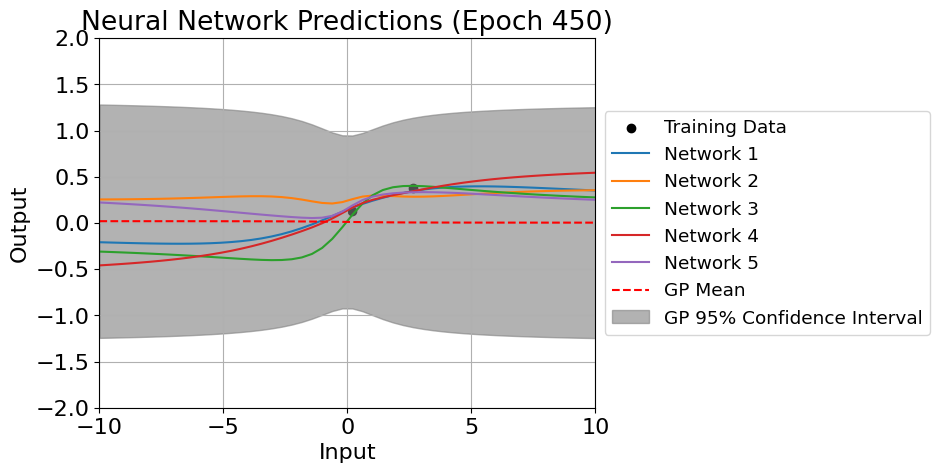

In [ ]:
#ANIMATION OF NETWORKS DURING TRAINING (varying epochs)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Set up parameters for the animation (re use parameters from first cell)
# learning_rate = 0.01
num_networks = 5  # Number of networks to animate
epochs_per_frame = 50  # Number of epochs to train per frame
total_frames = 10  # Total of frames in the animation

hidden_units = 500 #100                # Width of the hidden layer (n_1 in the paper)
learning_rate = 0.1 #0.1
scaled_lr = learning_rate / hidden_units  #Scaling as in [Lee et al. '19, Appendix F]

# Generate training data (same as before)
x_train = np.random.uniform(low=-5, high=5, size=(num_samples, 1))
y_train = np.sin(x_train) + 0.1 * np.random.randn(num_samples, 1)
# Generate data for plotting (same as before)
x_test = np.linspace(-10, 10, 50).reshape(-1, 1)

# Set a seed for reproducible training data generation
training_data_seed = 5
np.random.seed(training_data_seed)
torch.manual_seed(training_data_seed) # Set PyTorch seed for reproducibility

# Create the figure and axes for the animation
fig, ax = plt.subplots()
ax.scatter(x_train, y_train, color='black', label='Training Data')
lines = [ax.plot([], [], label=f'Network {i + 1}')[0] for i in range(num_networks)]
gp_mean_line, = ax.plot([], [], color='red', linestyle='--', label='GP Mean') # Add a line for GP mean
# Add a placeholder for the shaded region for GP confidence interval
gp_fill = ax.fill_between([], [], [], color='gray', alpha=0.6, label='GP 95% Confidence Interval')


ax.set_xlim([-10, 10])
ax.set_ylim([-2, 2])
ax.set_xlabel('Input')
ax.set_ylabel('Output')
ax.set_title('Neural Network Predictions')
ax.grid(True)

# Move the legend outside the plot area
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


# Define the animation function
def animate(frame):
    # Re-initialize necessary variables for each frame
    np.random.seed(training_data_seed) # Ensure same training data
    torch.manual_seed(training_data_seed) # Ensure reproducible PyTorch initialization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Re-get device

    epochs = frame * epochs_per_frame
    nn_outputs = train_batched_networks_pytorch(
        width=hidden_units,
        num_parallel_train_networks=num_networks,
        x_train_np_local=x_train,
        y_train_np_local=y_train,
        x_test_np_local=x_test,
        epochs_local=epochs,  # Use the accumulated epochs
        #lr_local=scaled_lr,
        lr_local=learning_rate,
        current_device=device
    )

    # Calculate GP mean and covariance for the current number of epochs
    if epochs == 0: # At initialization
        gp_mean = np.zeros_like(x_test)
        gp_cov = k2_test_test # Use the pre-calculated NNGP kernel
    else:
        #Itk = It(kinf_train_train, epochs * learning_rate)
        Itk = It(kinf_train_train, epochs * scaled_lr)
        gp_mean = (kinf_test_train @ Itk @ y_train).reshape(-1, 1)

        pz1 = k2_test_test
        pz2 = -k2_test_train @ Itk @ kinf_train_test
        pz3 = -kinf_test_train @ Itk @ k2_train_test
        pz4 = +kinf_test_train @ Itk @ k2_train_train @ Itk @ kinf_train_test
        gp_cov = pz1 + pz2 + pz3 + pz4

    # Ensure gp_cov is positive semi-definite for sampling
    gp_cov = gp_cov + np.eye(gp_cov.shape[0]) * 1e-6
    gp_std = np.sqrt(np.diag(gp_cov)) # Calculating gp_std from gp_cov

    for i, line in enumerate(lines):
        line.set_data(x_test, nn_outputs[i])

    gp_mean_line.set_data(x_test.ravel(), gp_mean.ravel()) # Update GP mean line

    # Update the GP confidence interval
    # Remove previous fill between collection if it exists
    global gp_fill # Declare gp_fill as global to modify the object created outside animate
    if gp_fill is not None:
        gp_fill.remove()
    gp_fill = ax.fill_between(
        x_test.ravel(),
        gp_mean.ravel() - 1.95*gp_std,
        gp_mean.ravel() + 1.95*gp_std,
        color='gray',
        alpha=0.6
    )

    ax.set_title(f'Neural Network Predictions (Epoch {epochs})')
    return lines + [gp_mean_line] + [gp_fill] # Include GP mean line and fill collection in returned list


# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=total_frames, blit=True, interval=100)

# Display the animation (in Colab, you might need to use HTML)
from IPython.display import HTML
html_animation = HTML(ani.to_jshtml())

# Print plot_info in a formatted way
print("-" * 40)
print("Animation Information (Varying Epochs):")
print(f"  Number of Networks: {num_networks}")
print(f"  Epochs per Frame: {epochs_per_frame}")
print(f"  Total Frames: {total_frames}")
print(f"  Hidden Units: {hidden_units}")
print(f"  Learning Rate: {learning_rate}")
print("-" * 40)  # Print a separator line

html_animation

Training Networks: 100%|██████████| 1000/1000 [00:01<00:00, 641.15it/s]


----------------------------------------
Animation Information (Varying Learning Rate):
  Number of Networks: 5
  Fixed Epochs: 1000
  Learning Rate per Frame: 0.2
  Total Frames: 10
  Hidden Units: 2000
----------------------------------------


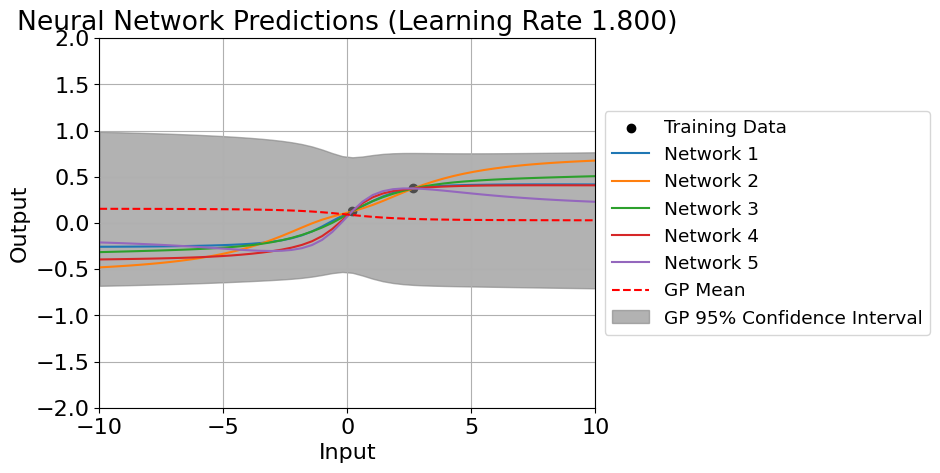

In [ ]:
#ANIMATION OF NETWORKS DURING TRAINING (varying learning_rate)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Set up parameters for the animation (re use parameters from first cell)
fixed_epochs = 1000 # Fixed number of epochs for each frame
num_networks = 5  # Number of networks to animate
lr_per_frame = 0.2 # Increase in learning rate per frame
total_frames = 10  # Total of frames in the animation

hidden_units = 2000 # Width of the hidden layer (n_1 in the paper)

# Generate training data (same as before)
#x_train = np.random.uniform(low=-5, high=5, size=(num_samples, 1))
#y_train = np.sin(x_train) + 0.1 * np.random.randn(num_samples, 1)
# Generate data for plotting (same as before)
#x_test = np.linspace(-10, 10, 50).reshape(-1, 1)

# Create the figure and axes for the animation
fig, ax = plt.subplots()
ax.scatter(x_train, y_train, color='black', label='Training Data')
lines = [ax.plot([], [], label=f'Network {i + 1}')[0] for i in range(num_networks)]
gp_mean_line, = ax.plot([], [], color='red', linestyle='--', label='GP Mean') # Add a line for GP mean
# Add a placeholder for the shaded region for GP confidence interval
gp_fill = ax.fill_between([], [], [], color='gray', alpha=0.6, label='GP 95% Confidence Interval')


ax.set_xlim([-10, 10])
ax.set_ylim([-2, 2])
ax.set_xlabel('Input')
ax.set_ylabel('Output')
ax.set_title('Neural Network Predictions')
ax.grid(True)

# Move the legend outside the plot area
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


# Define the animation function
def animate(frame):
    # Re-initialize necessary variables for each frame
    np.random.seed(training_data_seed) # Ensure same training data
    torch.manual_seed(training_data_seed) # Ensure reproducible PyTorch initialization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Re-get device

    current_lr = frame * lr_per_frame
    scaled_lr = current_lr / hidden_units

    nn_outputs = train_batched_networks_pytorch(
        width=hidden_units,
        num_parallel_train_networks=num_networks,
        x_train_np_local=x_train,
        y_train_np_local=y_train,
        x_test_np_local=x_test,
        epochs_local=fixed_epochs,  # Use the fixed number of epochs
        lr_local=current_lr, # Use true learning rate
        #lr_local=scaled_lr, # Use the scaled learning rate for training
        current_device=device
    )

    # Calculate GP mean and covariance for the current time (epochs * scaled_lr)
    current_time = fixed_epochs * scaled_lr

    # Calculate GP mean and covariance for the UNSCALED current time (epochs * current_lr)
    #current_time = fixed_epochs * current_lr

    if current_time == 0: # At initialization
        gp_mean = np.zeros_like(x_test)
        gp_cov = k2_test_test # Use the pre-calculated NNGP kernel
    else:
        Itk = It(kinf_train_train, current_time)
        gp_mean = (kinf_test_train @ Itk @ y_train).reshape(-1, 1)

        pz1 = k2_test_test
        pz2 = -k2_test_train @ Itk @ kinf_train_test
        pz3 = -kinf_test_train @ Itk @ k2_train_test
        pz4 = +kinf_test_train @ Itk @ k2_train_train @ Itk @ kinf_train_test
        gp_cov = pz1 + pz2 + pz3 + pz4

    # Ensure gp_cov is positive semi-definite for sampling
    gp_cov = gp_cov + np.eye(gp_cov.shape[0]) * 1e-6
    gp_std = np.sqrt(np.diag(gp_cov)) # Calculating gp_std from gp_cov

    for i, line in enumerate(lines):
        line.set_data(x_test, nn_outputs[i])

    gp_mean_line.set_data(x_test.ravel(), gp_mean.ravel()) # Update GP mean line

    # Update the GP confidence interval
    # Remove previous fill between collection if it exists
    global gp_fill # Declare gp_fill as global to modify the object created outside animate
    if gp_fill is not None:
        gp_fill.remove()
    gp_fill = ax.fill_between(
        x_test.ravel(),
        gp_mean.ravel() - 1.95*gp_std,
        gp_mean.ravel() + 1.95*gp_std,
        color='gray',
        alpha=0.6
    )

    ax.set_title(f'Neural Network Predictions (Learning Rate {current_lr:.3f})')
    return lines + [gp_mean_line] + [gp_fill] # Include GP mean line and fill collection in returned list


# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=total_frames, blit=True, interval=100)

# Display the animation (in Colab, you might need to use HTML)
from IPython.display import HTML
html_animation = HTML(ani.to_jshtml())

# Print plot_info in a formatted way
print("-" * 40)
print("Animation Information (Varying Learning Rate):")
print(f"  Number of Networks: {num_networks}")
print(f"  Fixed Epochs: {fixed_epochs}")
print(f"  Learning Rate per Frame: {lr_per_frame}")
print(f"  Total Frames: {total_frames}")
print(f"  Hidden Units: {hidden_units}")
print("-" * 40)  # Print a separator line

html_animation

Training Networks: 100%|██████████| 2000/2000 [00:04<00:00, 434.34it/s]


----------------------------------------
Animation Information (Varying Hidden Units):
  Number of Networks: 5
  Fixed Epochs: 2000
  Fixed Learning Rate: 0.1
  Hidden Units Range: [1000 1129 1276 1442 1629 1841 2080 2350 2655 3000]
----------------------------------------


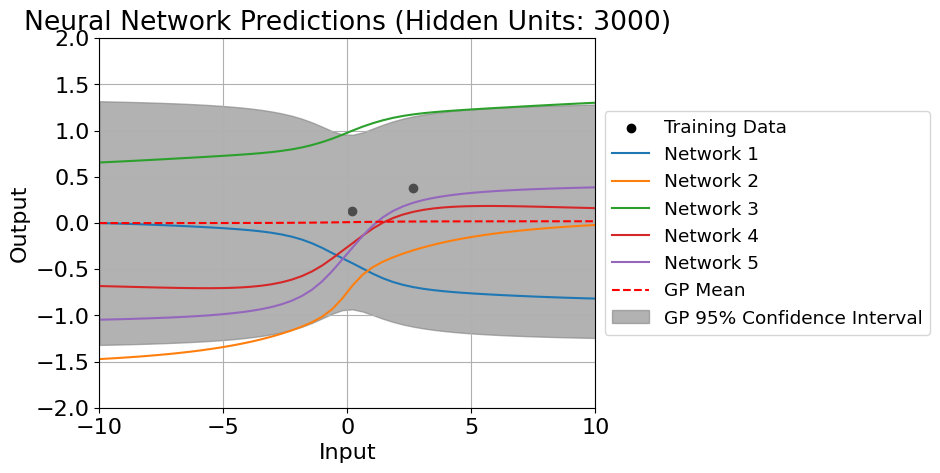

In [ ]:
#ANIMATION OF NETWORKS DURING TRAINING (varying hidden_units)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Set up parameters for the animation (re use parameters from first cell)
fixed_epochs = 2000 # Fixed number of epochs for each frame
fixed_learning_rate = 0.1 # Fixed learning rate
num_networks = 5  # Number of networks to animate

# Define parameters for varying hidden units logarithmically
#hidden_units_range = [10, 20, 50, 100, 200, 500, 1000] # Original list
start_hidden_units = 1000  # Starting number of hidden units
end_hidden_units = 3000  # Ending number of hidden units
total_frames = 10 # Total number of frames in the animation

# Generate hidden unit values logarithmically
hidden_units_range = np.logspace(np.log10(start_hidden_units), np.log10(end_hidden_units), total_frames).astype(int)
# Ensure unique values and sort them
hidden_units_range = np.unique(hidden_units_range)
hidden_units_range.sort()
total_frames = len(hidden_units_range) # Update total_frames based on unique values

# Generate training data (same as before)
#x_train = np.random.uniform(low=-5, high=5, size=(num_samples, 1))
#y_train = np.sin(x_train) + 0.1 * np.random.randn(num_samples, 1)
# Generate data for plotting (same as before)
#x_test = np.linspace(-10, 10, 50).reshape(-1, 1)

# Create the figure and axes for the animation
fig, ax = plt.subplots()
ax.scatter(x_train, y_train, color='black', label='Training Data')
lines = [ax.plot([], [], label=f'Network {i + 1}')[0] for i in range(num_networks)]
gp_mean_line, = ax.plot([], [], color='red', linestyle='--', label='GP Mean') # Add a line for GP mean
# Add a placeholder for the shaded region for GP confidence interval
gp_fill = ax.fill_between([], [], [], color='gray', alpha=0.6, label='GP 95% Confidence Interval')


ax.set_xlim([-10, 10])
ax.set_ylim([-2, 2])
ax.set_xlabel('Input')
ax.set_ylabel('Output')
ax.set_title('Neural Network Predictions')
ax.grid(True)

# Move the legend outside the plot area
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')


# Define the animation function
def animate(frame):
    # Re-initialize necessary variables for each frame
    np.random.seed(training_data_seed) # Ensure same training data
    torch.manual_seed(training_data_seed) # Ensure reproducible PyTorch initialization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Re-get device


    current_hidden_units = hidden_units_range[frame]
    scaled_lr = fixed_learning_rate / current_hidden_units

    nn_outputs = train_batched_networks_pytorch(
        width=current_hidden_units,
        num_parallel_train_networks=num_networks,
        x_train_np_local=x_train,
        y_train_np_local=y_train,
        x_test_np_local=x_test,
        epochs_local=fixed_epochs,  # Use the fixed number of epochs
        #lr_local=fixed_learning_rate, # Use the fixed learning rate
        lr_local = scaled_lr, # Use the scaled learning rate for training
        current_device=device
    )

    # Calculate GP mean and covariance for the current time (epochs * scaled_lr)
    current_time = fixed_epochs * scaled_lr

    # Calculate GP mean and covariance for the UNSCALED current time (epochs * fixed_learning_rate)
    #current_time = fixed_epochs * fixed_learning_rate

    # GP calculation for current hidden units (needed to get correct kernel for GP calculation)
    if activation_function == 'sigmoid':
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(current_hidden_units, W_std=1.0, b_std=0.0), stax.Sigmoid_like(),
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )
    elif activation_function == 'relu':
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(current_hidden_units, W_std=1.0, b_std=0.0), stax.Relu(),
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )
    elif activation_function == 'erf':
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(current_hidden_units, W_std=1.0, b_std=0.0), stax.Erf(),
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )

    kinf_test_train_jax = kernel_fn(x_test, x_train, 'ntk')
    kinf_train_train_jax = kernel_fn(x_train, x_train, 'ntk')
    k2_test_test_jax = kernel_fn(x_test, x_test, 'nngp')
    k2_test_train_jax = kernel_fn(x_test, x_train, 'nngp')
    k2_train_test_jax = kernel_fn(x_train, x_test, 'nngp')
    k2_train_train_jax = kernel_fn(x_train, x_train, 'nngp')

    kinf_test_train = np.array(kinf_test_train_jax.block_until_ready())
    kinf_train_train = np.array(kinf_train_train_jax.block_until_ready())
    k2_test_test = np.array(k2_test_test_jax.block_until_ready())
    k2_test_train = np.array(k2_test_train_jax.block_until_ready())
    k2_train_test = np.array(k2_train_test_jax.block_until_ready())
    k2_train_train = np.array(k2_train_train_jax.block_until_ready())
    kinf_train_test = kinf_test_train.T

    if current_time == 0: # At initialization (shouldn't happen with fixed_epochs > 0)
        gp_mean = np.zeros_like(x_test)
        gp_cov = k2_test_test # Use the pre-calculated NNGP kernel
    else:
        Itk = It(kinf_train_train, current_time)
        gp_mean = (kinf_test_train @ Itk @ y_train).reshape(-1, 1)

        pz1 = k2_test_test
        pz2 = -k2_test_train @ Itk @ kinf_train_test
        pz3 = -kinf_test_train @ Itk @ k2_train_test
        pz4 = +kinf_test_train @ Itk @ k2_train_train @ Itk @ kinf_train_test
        gp_cov = pz1 + pz2 + pz3 + pz4


    # Ensure gp_cov is positive semi-definite for sampling
    gp_cov = gp_cov + np.eye(gp_cov.shape[0]) * 1e-6
    gp_std = np.sqrt(np.diag(gp_cov)) # Calculating gp_std from gp_cov

    for i, line in enumerate(lines):
        line.set_data(x_test, nn_outputs[i])

    gp_mean_line.set_data(x_test.ravel(), gp_mean.ravel()) # Update GP mean line

    # Update the GP confidence interval
    # Remove previous fill between collection if it exists
    global gp_fill # Declare gp_fill as global to modify the object created outside animate
    if gp_fill is not None:
        gp_fill.remove()
    gp_fill = ax.fill_between(
        x_test.ravel(),
        gp_mean.ravel() - 1.95*gp_std,
        gp_mean.ravel() + 1.95*gp_std,
        color='gray',
        alpha=0.6
    )

    ax.set_title(f'Neural Network Predictions (Hidden Units: {current_hidden_units})')
    return lines + [gp_mean_line] + [gp_fill] # Include GP mean line and fill collection in returned list


# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=total_frames, blit=True, interval=500) # Increased interval for better viewing

# Display the animation (in Colab, you might need to use HTML)
from IPython.display import HTML
html_animation = HTML(ani.to_jshtml())

# Print plot_info in a formatted way
print("-" * 40)
print("Animation Information (Varying Hidden Units):")
print(f"  Number of Networks: {num_networks}")
print(f"  Fixed Epochs: {fixed_epochs}")
print(f"  Fixed Learning Rate: {fixed_learning_rate}")
print(f"  Hidden Units Range: {hidden_units_range}")
print("-" * 40)  # Print a separator line

html_animation

Epochs =  375 using finite time GP mean and covariance with t=3.7500.
Epochs =  500 using finite time GP mean and covariance with t=5.0000.
Epochs =  625 using finite time GP mean and covariance with t=6.2500.
Epochs =  750 using finite time GP mean and covariance with t=7.5000.
Epochs =  875 using finite time GP mean and covariance with t=8.7500.


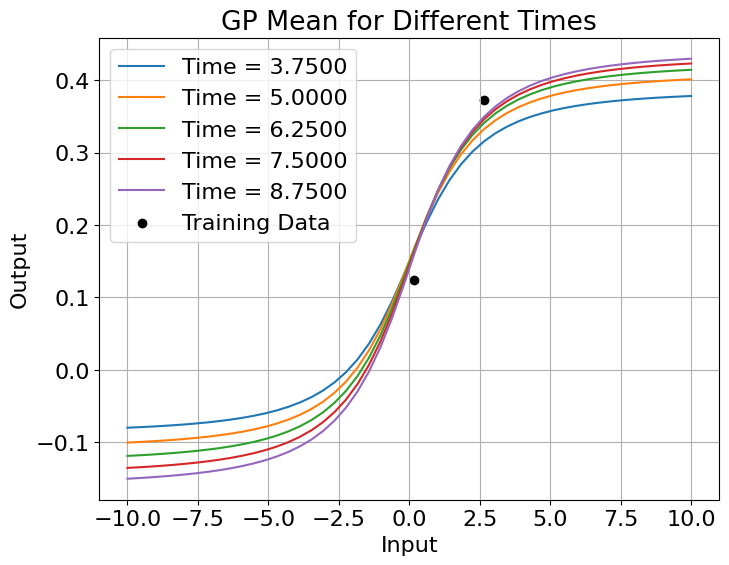

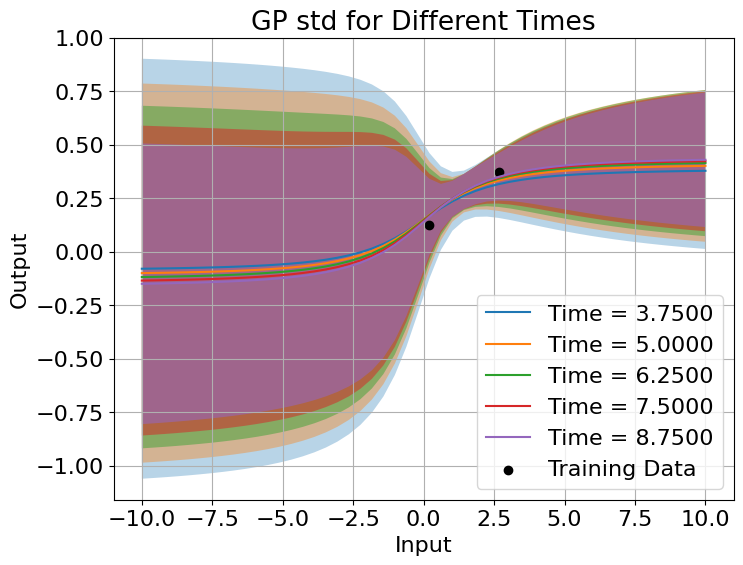

In [ ]:
#PLOTS OF GP FOR DIFFERENT EPOCHS
# Re use parameters from previous cells

# Select different epochs for testing

#my_range = [10, 50, 100, 500, 1000]
#my_range = [10000,50000,100000,500000,1000000]
my_range = [375,500,625,750,875]
#x_train = np.random.uniform(low=-5, high=5, size=(4, 1))
#y_train = np.sin(x_train) + 0.1 * np.random.randn(4, 1)  # Example function to learn

learning_rate = 0.01
activation_function = 'sigmoid'

gp_means_epochs = []
gp_stds_epochs = [] # Store standard deviations as well

for ran in my_range:
    # GP calculation
    # Select activation function for NTK computation
    if activation_function == 'sigmoid':
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(100, W_std=1.0, b_std=0.0), stax.Sigmoid_like(),
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )
    elif activation_function == 'relu':
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(100, W_std=1.0, b_std=0.0), stax.Relu(),  # Use stax.Relu() for ReLU
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )
    elif activation_function == 'erf':  # Using built-in stax.Erf
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(100, W_std=1.0, b_std=0.0), stax.Erf(),
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )

    # Convert JAX arrays to NumPy for subsequent scipy/numpy operations if needed
    k2_test_test_jax = kernel_fn(x_test, x_test, 'nngp')
    k2_test_train_jax = kernel_fn(x_test, x_train, 'nngp')
    k2_train_test_jax = kernel_fn(x_train, x_test, 'nngp')
    k2_train_train_jax = kernel_fn(x_train, x_train, 'nngp')

    kinf_test_train_jax = kernel_fn(x_test, x_train, 'ntk')
    kinf_train_train_jax = kernel_fn(x_train, x_train, 'ntk')

    # Convert JAX arrays to NumPy. .block_until_ready() is good practice for JAX before conversion.
    k2_test_test = np.array(k2_test_test_jax.block_until_ready())
    k2_test_train = np.array(k2_test_train_jax.block_until_ready())
    k2_train_test = np.array(k2_train_test_jax.block_until_ready())
    k2_train_train = np.array(k2_train_train_jax.block_until_ready())

    kinf_test_train = np.array(kinf_test_train_jax.block_until_ready())
    kinf_train_train = np.array(kinf_train_train_jax.block_until_ready())
    # kinf_train_test is just kinf_test_train.T
    kinf_train_test = kinf_test_train.T

    # GP mean and covariance calculation
    # Ensure time is non-zero if epochs > 0, otherwise Itk might be ill-defined or zero.
    # If epochs=0, learning_rate*epochs = 0. expm(0) = I. So I - I = 0. Itk -> 0.
    # This means gp_mean becomes 0 if epochs=0 and lr*epochs is the time.
    # The theory for t=0 (initialization) is simpler:
    # Mean_t0 = 0 (if biases are 0 and centered weights)
    # Cov_t0 = NNGP kernel (k2_test_test - k2_test_train @ k2_train_train_inv @ k2_train_test)
    # The provided formula is for finite time t > 0 with gradient descent.

    current_time = ran * learning_rate # Calculate time

    if current_time == 0: # At initialization
        gp_mean = np.zeros_like(x_test @ y_train.T)
        gp_cov = k2_test_test
        print("Epochs = 0, using GP mean (0) and covariance (NNGP K(x_test,x_test)).")

    else: # epochs > 0
        Itk = It(kinf_train_train, current_time) # Use current_time as time_param
        gp_mean = kinf_test_train @ Itk @ y_train

        pz1 = k2_test_test
        pz2 = -k2_test_train @ Itk @ kinf_train_test
        pz3 = -kinf_test_train @ Itk @ k2_train_test
        pz4 = +kinf_test_train @ Itk @ k2_train_train @ Itk @ kinf_train_test
        gp_cov = pz1 + pz2 + pz3 + pz4
        print("Epochs = ", str(ran), f"using finite time GP mean and covariance with t={current_time:.4f}.")


    # Ensure gp_cov is positive semi-definite for sampling
    gp_cov = gp_cov + np.eye(gp_cov.shape[0]) * 1e-6

    gp_std = np.sqrt(np.diag(gp_cov)) # Calculating gp_std from gp_cov

    # ... #
    gp_means_epochs.append(gp_mean)
    gp_stds_epochs.append(gp_std) # Store stds


plt.figure(figsize=(8, 6))  # Adjust figure size as desired
for i, epochs_val in enumerate(my_range):
    current_time = epochs_val * learning_rate # Calculate time for legend
    plt.plot(x_test, gp_means_epochs[i], label=f'Time = {current_time:.4f}')
plt.scatter(x_train, y_train, color='black', label='Training Data')
plt.title('GP Mean for Different Times')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))  # Adjust figure size as desired

#For plotting with transparencies:
max_epoch = np.max(my_range)
for i, epochs_val in enumerate(my_range):
    current_time = epochs_val * learning_rate # Calculate time for legend

    # Use the mean and std from the corresponding epoch value
    current_mean = gp_means_epochs[i]
    current_std = gp_stds_epochs[i]
    plt.plot(x_test, current_mean, label=f'Time = {current_time:.4f}')
    plt.fill_between(
        x_test.ravel(),
        current_mean[:, 0] - 1.96 * current_std, # Select the first column to match std shape
        current_mean[:, 0] + 1.96 * current_std, # Select the first column to match std shape
        alpha= 0.1 + epochs_val / (2*max_epoch),  # Adjust alpha for transparency
    )
plt.scatter(x_train, y_train, color='black', label='Training Data')
plt.title('GP std for Different Times')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

Testing activation functions

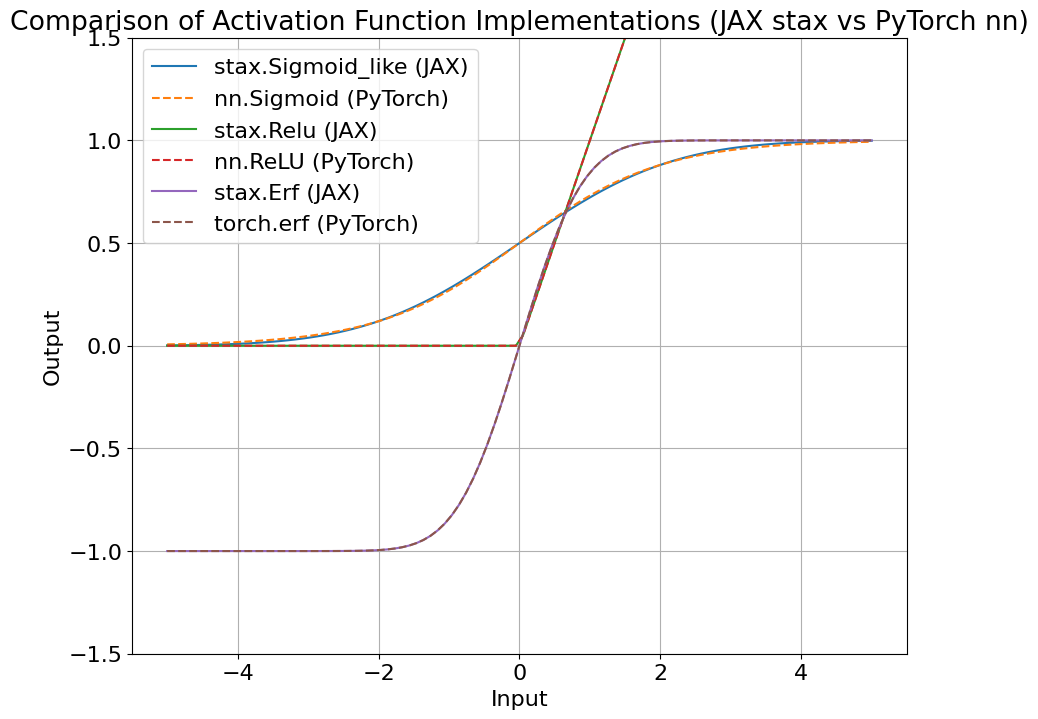

Numerical comparison at specific points:

Sigmoid:
  stax: [0.2780141  0.5        0.72198594]
  nn: [0.26894143 0.5        0.7310586 ]

ReLU:
  stax: [0. 0. 1.]
  nn: [0. 0. 1.]

Erf:
  stax: [-0.84270084  0.          0.84270084]
  torch: [-0.8427008  0.         0.8427008]


In [ ]:
# Test stax vs nn activation functions with plotting

import jax.numpy as jnp
import torch
import torch.nn as nn
from neural_tangents import stax
import numpy as np
import matplotlib.pyplot as plt
from jax import random # Import random from jax

# Sample data for plotting
plot_input_np = np.linspace(-5, 5, 100).reshape(-1, 1).astype(np.float32)
plot_input_jax = jnp.array(plot_input_np)
plot_input_torch = torch.from_numpy(plot_input_np)

# Using stax activation functions
init_fn_sigmoid_stax, apply_fn_sigmoid_stax, _ = stax.serial(stax.Sigmoid_like())
_, params_sigmoid_stax = init_fn_sigmoid_stax(random.PRNGKey(0), (-1, 1))
output_sigmoid_stax = apply_fn_sigmoid_stax(params_sigmoid_stax, plot_input_jax)

init_fn_relu_stax, apply_fn_relu_stax, _ = stax.serial(stax.Relu())
_, params_relu_stax = init_fn_relu_stax(random.PRNGKey(0), (-1, 1))
output_relu_stax = apply_fn_relu_stax(params_relu_stax, plot_input_jax)

init_fn_erf_stax, apply_fn_erf_stax, _ = stax.serial(stax.Erf())
_, params_erf_stax = init_fn_erf_stax(random.PRNGKey(0), (-1, 1))
output_erf_stax = apply_fn_erf_stax(params_erf_stax, plot_input_jax)


# Using nn activation functions
sigmoid_torch = nn.Sigmoid()
output_sigmoid_torch = sigmoid_torch(plot_input_torch)

relu_torch = nn.ReLU()
output_relu_torch = relu_torch(plot_input_torch)

# PyTorch doesn't have a built-in nn.Erf. We can use torch.erf
output_erf_torch = torch.erf(plot_input_torch)

# Plotting
plt.figure(figsize=(10, 8))

plt.plot(plot_input_np.ravel(), output_sigmoid_stax.ravel(), label='stax.Sigmoid_like (JAX)', linestyle='-')
plt.plot(plot_input_np.ravel(), output_sigmoid_torch.numpy().ravel(), label='nn.Sigmoid (PyTorch)', linestyle='--')

plt.plot(plot_input_np.ravel(), output_relu_stax.ravel(), label='stax.Relu (JAX)', linestyle='-')
plt.plot(plot_input_np.ravel(), output_relu_torch.numpy().ravel(), label='nn.ReLU (PyTorch)', linestyle='--')

plt.plot(plot_input_np.ravel(), output_erf_stax.ravel(), label='stax.Erf (JAX)', linestyle='-')
plt.plot(plot_input_np.ravel(), output_erf_torch.numpy().ravel(), label='torch.erf (PyTorch)', linestyle='--')


plt.title('Comparison of Activation Function Implementations (JAX stax vs PyTorch nn)')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.ylim([-1.5, 1.5]) # Set y-axis limits for better visualization
plt.show()

# Optional: Print some values for numerical comparison
print("Numerical comparison at specific points:")
test_points = np.array([[-1.0], [0.0], [1.0]], dtype=np.float32)
test_points_jax = jnp.array(test_points)
test_points_torch = torch.from_numpy(test_points)

print("\nSigmoid:")
print("  stax:", apply_fn_sigmoid_stax(params_sigmoid_stax, test_points_jax).ravel())
print("  nn:", nn.Sigmoid()(test_points_torch).numpy().ravel())

print("\nReLU:")
print("  stax:", apply_fn_relu_stax(params_relu_stax, test_points_jax).ravel())
print("  nn:", nn.ReLU()(test_points_torch).numpy().ravel())

print("\nErf:")
print("  stax:", apply_fn_erf_stax(params_erf_stax, test_points_jax).ravel())
print("  torch:", torch.erf(test_points_torch).numpy().ravel())